# General

## Dataset
https://www.kaggle.com/datasets/blastchar/telco-customer-churn

# TODO:
### David:


In [25]:
# Environment and sklearn package must be updated to handle at least sklearn version 1.0 for RocCurveDisplay to work
# Using anaconda CMD.exe Prompt run "conda update --all" to update
import sklearn
print(sklearn.__version__)
del sklearn

1.0.2


### Ideas for the final report.  What is the goal of our final project?

Primary

* Make RandomForestClassifier work and figure out how to optimize its predictive performance.
* Show that it performs better than other algorithms.

Secondary

* Focus it more on understanding why an ML algorithm performs better
* (Overfitting, high correlation, other pitfalls of ML algorithms)?

In [126]:
## Imports & Settings
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split as split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as skm
from sklearn.metrics import accuracy_score

# display all columns and rows:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from IPython.core.display import HTML

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from copy import deepcopy

<h1 style='color:orange'>NOTE</h1>

### Breiman (2001) Section 5:

* If, after feature selection, it is found that only a handful of features are actually any good, Breiman seems to suggest combining these features into some additional features for datasets with fewer than 3000 instances.  See paper for implementation.

### Section 5.1:

* Breiman on handling non-binary categorical variables when forming combined features.

In [124]:
## Dataset & Preprocessing

# Dataset
df_original = pd.read_csv('dataset/telco-customer-churn.csv', index_col=0)
df = df_original.copy()

# Label Encoding (converting categorical to numerical)
categorical_columns = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines','InternetService',
    'OnlineSecurity', 'OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
    'StreamingMovies','Contract','PaperlessBilling','PaymentMethod', 'Churn'
]

# convert and replace categorical columns with numerical data
# encoding is done with categorical labels that sorted alphabetically so df = ['c','z','a'] will always encode to [1,2,0]
for col in categorical_columns:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes

# Dataset 1: where rows with blank TotalCharges ' ' are replaced with 0
df_0 = df.copy()
df_0['TotalCharges'].replace(" ", 0, inplace=True)
df_0['TotalCharges'] = df_0['TotalCharges'].astype(float)

# Dataset 2: where rows with blank TotalCharges ' ' are deleted
df_d = df.copy()
df_d.drop(df_d[df_d.TotalCharges == " "].index, inplace=True)
df_d['TotalCharges'] = df_d['TotalCharges'].astype(float)


# Dataset 3: where rows with blank TotalCharges ' ' are replaced with the mean of TotalCharges column
df_m = df.copy()
total_charges_mean = (df_d['TotalCharges'].mean()) # mean from previously calculated dataset
df_m['TotalCharges'].replace(" ", total_charges_mean, inplace=True)
df_m['TotalCharges'] = df_m['TotalCharges'].astype(float)


# Using Dataset 3
df = df_m

# Define Dataset & Splits
X = df.drop("Churn", axis=1)
y = df["Churn"]
X_train, X_test, y_train, y_test = split(df.drop("Churn", axis=1),  df["Churn"], test_size=0.1)

### Feature Selection

### Mean decrease in impurity

,Accuracy,Threshold,K-features,Columns
0.8,0.781560,0.160000,2,"['MonthlyCharges', 'TotalCharges']"
0.9,0.774468,0.090000,3,"['tenure', 'MonthlyCharges', 'TotalCharges']"
0.91,0.774468,0.082000,3,"['tenure', 'MonthlyCharges', 'TotalCharges']"
0.92,0.773050,0.074000,4,"['tenure', 'Contract', 'MonthlyCharges', 'TotalCharges']"
0.93,0.773050,0.065000,4,"['tenure', 'Contract', 'MonthlyCharges', 'TotalCharges']"
0.94,0.773050,0.056000,4,"['tenure', 'Contract', 'MonthlyCharges', 'TotalCharges']"
0.95,0.787234,0.048000,5,"['tenure', 'Contract', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']"
0.96,0.782979,0.038000,7,"['tenure', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']"
0.97,0.782979,0.029000,7,"['tenure', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']"
0.98,0.787234,0.020000,15,"['gender', 'SeniorCitizen', 'Partner', 'tenure', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']"


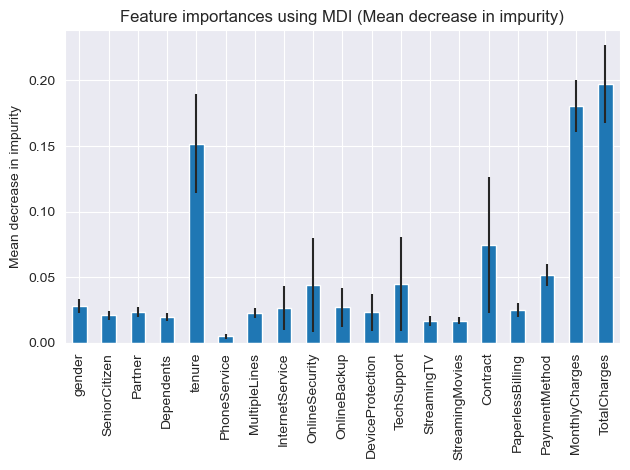

In [132]:
forest = RandomForestClassifier(random_state=0)
forest.fit(X, y)
feature_names = X.columns.values.tolist()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances_mdi = pd.Series(importances, index=feature_names)

# Plot feature importance
fig, ax = plt.subplots()
forest_importances_mdi.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI (Mean decrease in impurity)")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


# Calculate feature selection table
# We want to remove all features that are either one or zero (on or off) in more than n percent of the samples
threshold_percentiles = [0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
thresholds = [round((probability * (1 - probability)), 3) for probability in threshold_percentiles]
threshold_dict = {
    f'{threshold_percentiles[i]}': forest_importances_mdi[forest_importances_mdi > thresholds[i]].index.tolist()
    for i in range(len(thresholds))
}

threshold_results = { key:[columns] for key, columns in threshold_dict.items()}

for key, columns in threshold_dict.items():
    # fit & train an RF classifier with certain columns that passed threshold
    clf_i = RandomForestClassifier(random_state=0)
    X_train_i = X_train[columns]
    X_test_i = X_test[columns]
    y_pred = clf_i.fit(X_train_i, y_train).predict(X_test_i)

    threshold_results[key] = [accuracy_score(y_test, y_pred), thresholds[threshold_percentiles.index(float(key))], len(columns), columns]

feature_selection_results = pd.DataFrame.from_dict(threshold_results, orient='index', columns=['Accuracy', 'Threshold',  'K-features', 'Columns'])
feature_selection_results = feature_selection_results.style.set_caption("Accuracy of a RF Classifier using columns within variance threshold")

# Show feature selection vs accuracy results table
display(HTML(feature_selection_results.to_html()))

### Feature permutation


MonthlyCharges      0.105850
tenure              0.103748
Contract            0.100227
TotalCharges        0.099290
PaymentMethod       0.056695
TechSupport         0.048857
PaperlessBilling    0.046969
OnlineSecurity      0.045819
InternetService     0.041360
OnlineBackup        0.029845
MultipleLines       0.027332
gender              0.026906
Partner             0.023910
DeviceProtection    0.021937
SeniorCitizen       0.021397
Dependents          0.020716
StreamingMovies     0.020602
StreamingTV         0.019310
PhoneService        0.001775
dtype: float64


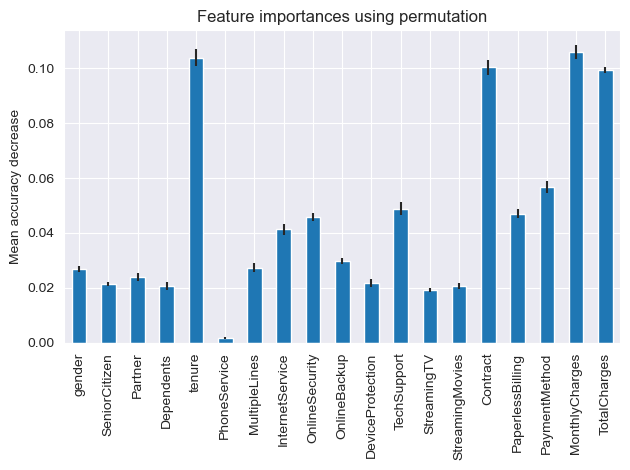

In [29]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, X, y, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances_pi = pd.Series(result.importances_mean, index=feature_names)
print(forest_importances_pi.sort_values(ascending=False))

fig, ax = plt.subplots()
forest_importances_pi.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

<h1 style='color:orange'>NOTE</h1>

### Breiman (2001) Section 9:

* If the input dataset is just a combination of many "weak" (low-variance) features, a higher 'max_features' value will perform better so long as the features have low correlation.

### Probst (2018) Section 2.3:

The formula for Area Under the Curve of a Random Forest for binary classification (either 1 or 0) is:

$AUC = \frac{\sum_{i=1}^{n_1} \sum_{j=1}^{n_2} S(\hat{p}_i^*,\hat{p}_j^{**})}{n_1n_2}$

* $n_1 =$ The number of observations whose class is predicted to be 1
* $n_2 =$ The number of observations whose class is predicted to be 0
* $\hat{p}_{i}^*=$ The number of trees that predicted 1 for the $n_1^{th}$ instance divided by the number of trees in the forest
* $\hat{p}_{j}^{**}=$ The number of trees that predicted 1 for the $n_2^{th}$ instance divided by the number of trees in the forest

$S(\hat{p}_i^*,\hat{p}_j^{**}) =$ A function that returns the following:

* If $(\hat{p}_i^* < \hat{p}_j^{**})$, return 0.0
* If $(\hat{p}_i^* = \hat{p}_j^{**})$, return 0.5
* If $(\hat{p}_i^* > \hat{p}_j^{**})$, return 1.0

The larger this value, the better the classifier is.

Unsure if this is what's implemented by sklearn.

Training 4 classifiers...
	{'max_features': 1, 'max_depth': 3, 'n_estimators': 100, 'max_samples': 0.6666666666666666, 'oob_score': True, 'n_jobs': -1}
	{'max_features': 1, 'max_depth': 3, 'n_estimators': 200, 'max_samples': 0.6666666666666666, 'oob_score': True, 'n_jobs': -1}
	{'max_features': 1, 'max_depth': 3, 'n_estimators': 500, 'max_samples': 0.6666666666666666, 'oob_score': True, 'n_jobs': -1}
	{'max_features': 1, 'max_depth': 3, 'n_estimators': 1000, 'max_samples': 0.6666666666666666, 'oob_score': True, 'n_jobs': -1}


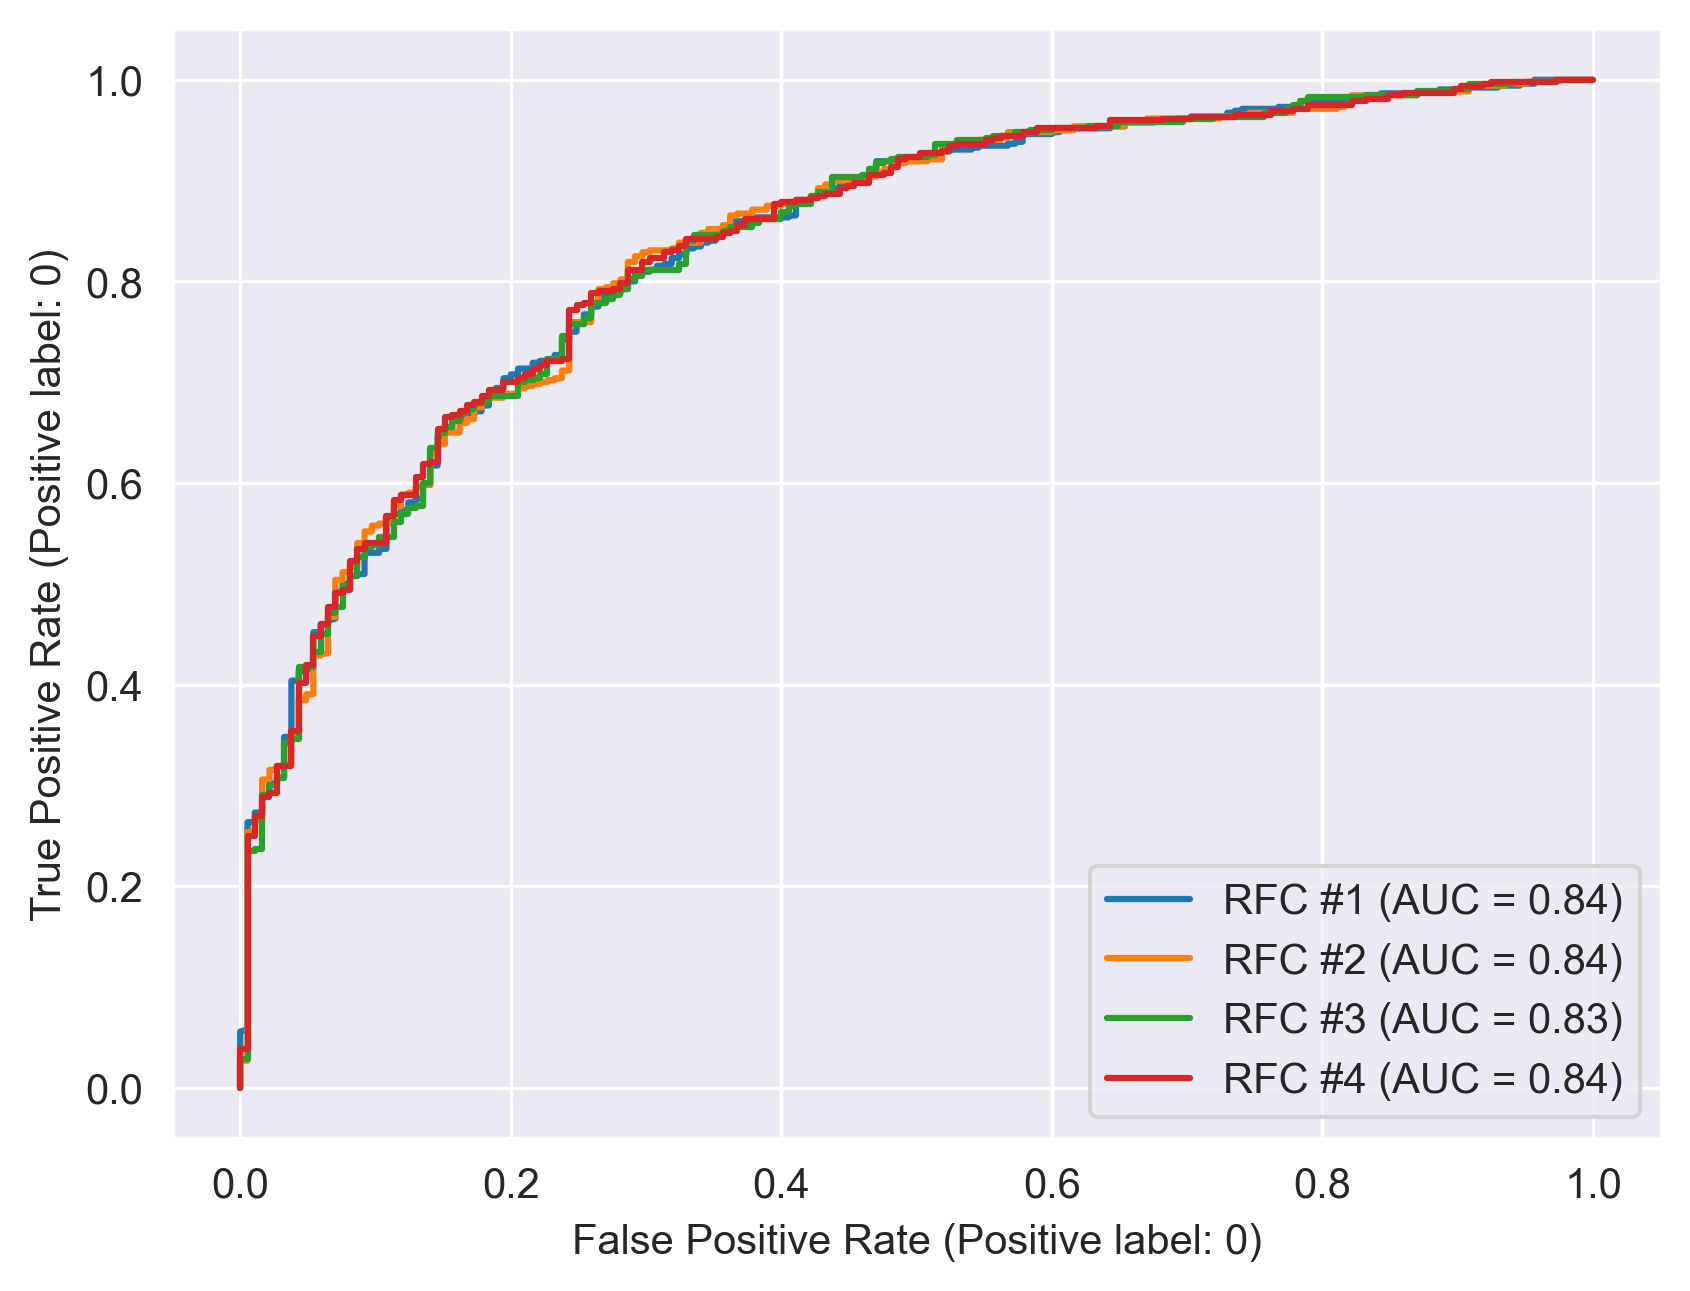

In [30]:
## Model
class RFC:
    '''
    Parameters:
      * X = A pandas.DataFrame of features
      * y = An associative (same index as X) pandas.Series of labels
      * hyperParameters = A dict whose keys correspond to the parameters of
        RandomForestClassifer and whose values are lists of arguments for those
        parameters
    Other notes:
      * Research paper references throughout this class are done in this manner:
         - Breiman (2001) = B
         - Probst  (2018) = P
        Section and subsection numbers will be added after these aliases like
        B2.1 to show that a comment refers to Breiman (2001) Section 2 Subsection 1
    '''
    def __init__(self, hyperParameters={}):
        hyperParams = \
            self.__getDefaultParams__() if len(hyperParameters) == 0 else self.__validateParams__(hyperParameters)
        self.params = self.__getParamCombos__(hyperParams)
        self.classifiers = []
    
    def __getDefaultParams__(self):
        ''' Supplies default parameters to test based on what our source papers
            suggest are generally good.
        '''
        out = {}
        ''' B4
            Suggests selecting more than 1 features to split a node with
            doesn't perform any better than selecting 1 so long as we have a high
            number of trees.
            
            sklearn sets its default 'max_features'='sqrt', so this is added as one of
            our defaults to investigate why.  Did they find that 'sqrt' performs better
            than Breiman's suggested 1?
        '''
        out['max_features'] = [1, 'sqrt']
        ''' P5.3
            Suggests that the biggest performance gain is experienced by the first 100
            trees.  However, lower 'max_samples' values, lower 'max_depth' values, and
            higher 'max_features' values reduce inter-tree correlation and therefore
            increase the number of trees needed to reach convergence.
        '''
        out['max_depth'] = [None, 3]
        out['n_estimators'] = [100, 200]
        ''' B3
            Suggests each bootstrap sample should ideally have 2/3s the length of X.
        '''
        out['max_samples'] = [float(2/3)]
        
        out['oob_score'] = [True]
        out['n_jobs'] = [-1]
        return out

    def __validateParams__(self, params):
        ''' Removes any misspelled or non-existent-in-RandomForestClassifier
            parameter name keys from the dict passed in by the caller.
        '''
        VALID = ['n_estimators', 'criterion', 'max_depth', 'min_samples_split',
                 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features',
                 'max_leaf_nodes', 'min_impurity_decrease', 'boostrap',
                 'oob_score','n_jobs', 'random_state', 'verbose', 'warm_start',
                 'class_weight', 'ccp_alpha', 'max_samples']
        invalidKeys = []
        validatedParams = deepcopy(params)
        for key in params:
            if key not in VALID:
                validatedParams.pop(key)
                invalidKeys += [key]
        if len(invalidKeys) > 0:
            print("These are not valid RandomForestClassifier parameter names:\n{}\n".format(invalidKeys) + \
                  "They will not be tuned by GridSearchCV\n")
        return validatedParams if len(validatedParams) > 0 else self.__getDefaultParams__()
    
    def __getParamCombos__(self, dictParams):
        # Assemble a dict for each unique combination of hyper parameters.  These dicts can be passed into
        # a function to supply named arguments
        combinations = []
        for param, valList in dictParams.items():
            if len(combinations) > 0:
                for i in range(len(combinations)):
                    base = combinations.pop(0)
                    for val in valList:
                        newCombo = deepcopy(base)
                        newCombo[param] = val
                        combinations.append(newCombo)
            else:
                for val in valList:
                    combinations.append({param: val})
        return combinations
    
    def train(self, trainX, trainY):
        ''' Train an RFC for each unique combination of hyperparameters
        Code references:
          * Passing named arguments to a function with a dict of names,vals
            https://stackoverflow.com/questions/334655/passing-a-dictionary-to-a-function-as-keyword-parameters
        '''
        print("Training {} classifiers...".format(len(self.params)))
        for dictParams in self.params:
            print("\t{}".format(dictParams))
            newRfc = RandomForestClassifier(**dictParams)
            newRfc.fit(trainX, trainY)
            self.classifiers.append(newRfc)
            
    def showRocAuc(self, testX, testY):
        if len(self.classifiers) == 0:
            raise AttributeError("No classifiers have been trained yet.  You must call .train() to create " + \
                                 "some classifiers to display.")

        fig = plt.figure(dpi=300)
        axes = plt.gca()
        for i in range(len(self.classifiers)):
            skm.RocCurveDisplay.from_estimator(
                self.classifiers[i],
                testX,
                testY,
                pos_label=0,
                name="RFC #{}".format(i+1),
                ax=axes)


## Testing non-default hyper parameters
X_train, X_test, y_train, y_test = split(df.drop("Churn", axis=1),  df["Churn"], test_size=0.1)
rfc = RFC(hyperParameters={
    'max_features': [1],
    'max_depth': [3],
    'n_estimators': [100, 200, 500, 1000],
    'max_samples': [float(2/3)],
    'oob_score': [True],
    'n_jobs': [-1]
})
rfc.train(X_train, y_train)
rfc.showRocAuc(X_test, y_test)

{'max_features': 1, 'max_depth': 3, 'n_estimators': 100, 'max_samples': 0.6666666666666666, 'oob_score': True, 'n_jobs': -1}

              precision    recall  f1-score   support

           0       1.00      0.74      0.85       701
           1       0.02      1.00      0.04         4

    accuracy                           0.74       705
   macro avg       0.51      0.87      0.45       705
weighted avg       0.99      0.74      0.85       705



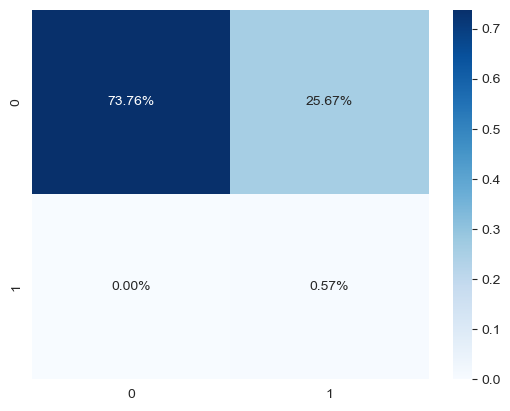

In [31]:
## Metrics

# Get predictions
y_pred = rfc.classifiers[0].predict(X_test)

# Confusion Matrix
cf = skm.confusion_matrix(y_pred, y_test)
sns.heatmap(cf/np.sum(cf), fmt='.2%', annot=True, cmap='Blues')

# Classification Report
print(rfc.params[0], end="\n\n")
print(skm.classification_report(y_pred, y_test))